Author: Abdelmalik Moujahid -- abdelmalik.moujahid@uc3m.es

Date: March 15, 2017

<b> Solved by: Alessandro La Corte </b>
<br/>
<b> Email: 100355025@alumnos.uc3m.es </b>


# Machine Learning

## Session 4: Predicting house prices with GP


The aim of this session is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). The problem is the prediction of the house prices using the Housing Data Set from  <a href = https://archive.ics.uci.edu/ml/datasets/Housing>  UCI repository</a> that you can also download from scikit learn <a href = http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html> here</a>.


In [2]:
#All imports

import numpy                   as np
import GPy
import matplotlib.pyplot       as plt
import math
from sklearn.datasets          import load_boston
from sklearn                   import cross_validation
from matplotlib                import pyplot as plt 
from sklearn.model_selection   import LeaveOneOut
from sklearn.metrics           import mean_absolute_error
from sklearn.metrics           import mean_squared_error

In [3]:
def rmse(Y, Ystar):
        return np.sqrt(np.mean((Y-Ystar)**2))

### 1. Loading and preparing the data

* Download the dataset
* Divide the dataset into train (400) and test (106) datasets
* Check the range of prices in the train and test datasets

In [4]:
boston = load_boston()

X = boston.data
# y = boston.target
y = boston.target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=106, random_state=42)

#The kernels requiere the shape of y to be of (number,1)
y_train = np.reshape(y_train, (y_train.size,1))
y_test = np.reshape(y_test, (y_test.size,1))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

print "The range of values of the X Train dataset ({},{})".format(np.amin(X_train), np.amax(X_train))
print "The range of values of the X Test dataset ({},{})".format(np.amin(X_test), np.amax(X_test))

print "The range of values of the y Train dataset ({},{})".format(np.amin(y_train), np.amax(y_train))
print "The range of values of the y Test dataset ({},{})".format(np.amin(y_test), np.amax(y_test))


(400, 13)
(106, 13)
(400, 1)
(106, 1)
The range of values of the X Train dataset (0.0,711.0)
The range of values of the X Test dataset (0.0,711.0)
The range of values of the y Train dataset (5.0,50.0)
The range of values of the y Test dataset (5.0,50.0)



### 2. Setting and optimizing the model

On the training data set:

a) Build a GP regression model based on an exponentiated quadratic covariance function

b) Fit the covariance function parameters and noise to the data  

On the test data set:

c) Plot and evaluate the prediction error using the opmitized parameters

d) Try to combine various covariance functions using the element-wise product or the sum of two kernels, and repeat steps b) and c). Comments the results.

<h1><b> Build a GP regression model based on an exponentiated quadratic covariance function</b></h1>

In [5]:
# The data has 13 dimensions
kern = GPy.kern.RBF(input_dim=13)
kern

<h1><b>Fit the covariance function parameters and noise to the data </b></h1>

Using the train set a Gaussian process regressor is fitted using the previous kernel:

In [13]:
model = GPy.models.GPRegression(X_train, y_train, kern)
print model


Name : GP regression
Objective : 1885.04655251
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  1782892.20087  |      +ve      |        
  rbf.lengthscale          |  427.587123083  |      +ve      |        
  Gaussian_noise.variance  |            1.0  |      +ve      |        


Optimizing the model fitted only once and showing the fitted parameters (variance, lengthscale, noise)

In [14]:
#Doing one optimization
model.optimize()
model.log_likelihood.im_self

Now running several optimization over the constraint positive parameters:

In [15]:
#Running several optimizations
model.constrain_positive('.*rbf_variance')
model.constrain_positive('.*lengthscale' )
model.constrain_positive('.*noise')
model.optimize_restarts(num_restarts=5)
print model

Optimization restart 1/5, f = 1189.55704146
Optimization restart 2/5, f = 1189.55705149
Optimization restart 3/5, f = 1212.24798734
Optimization restart 4/5, f = 1189.55703711
Optimization restart 5/5, f = 1189.5570371

Name : GP regression
Objective : 1189.5570371
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  1782639.46906  |      +ve      |        
  rbf.lengthscale          |  427.573143864  |      +ve      |        
  Gaussian_noise.variance  |  8.58741680542  |      +ve      |        


<h1><b>Plot and evaluate the prediction error using the opmitized parameters </b></h1>

Lets take a look a the optimized model:

In [16]:
print model


Name : GP regression
Objective : 1189.5570371
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  1782639.46906  |      +ve      |        
  rbf.lengthscale          |  427.573143864  |      +ve      |        
  Gaussian_noise.variance  |  8.58741680542  |      +ve      |        


Given that the *model* is optimizied, lets first plot several prediction error plots:

In [37]:
%matplotlib inline

[mean,var] = model.predict(X_test, full_cov=False)

lower =mean-2*(var**0.5)
upper =mean+2*(var**0.5)

Lets plot in Blue the price of the original data, in red the predicted price and in a green bar the confidence interval. 

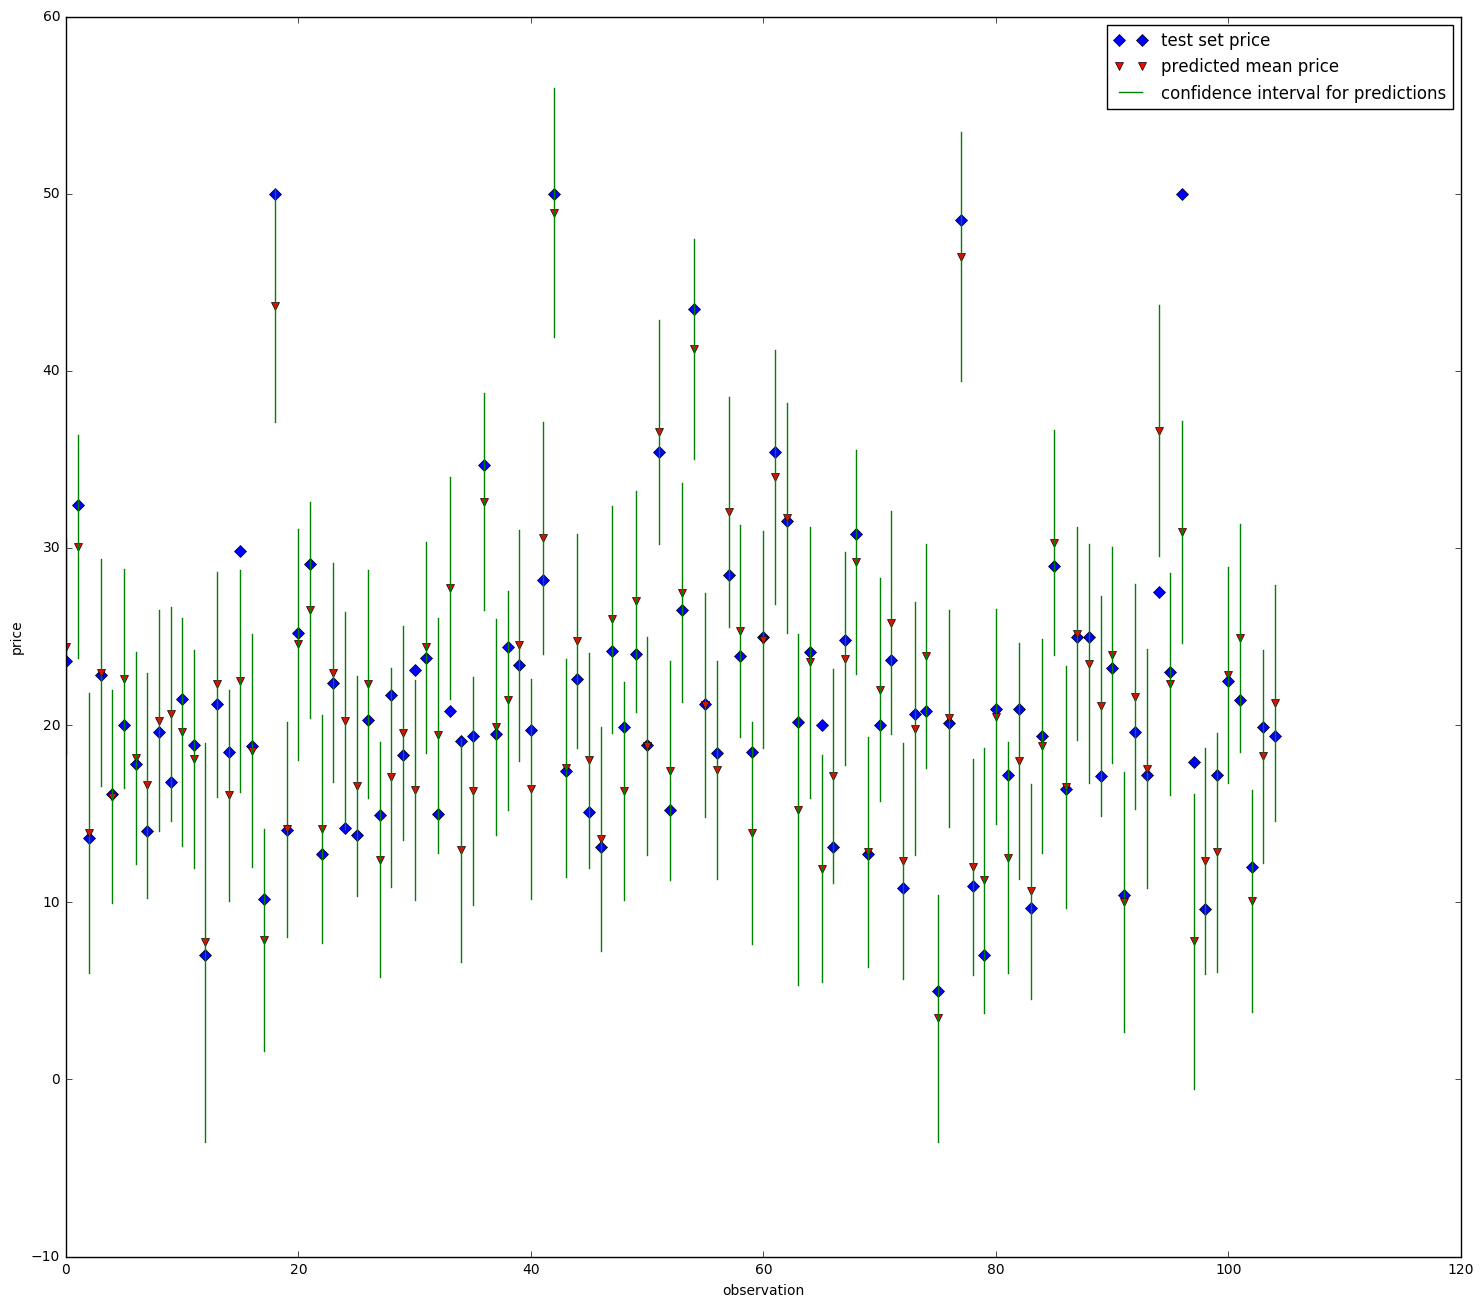

In [38]:
%matplotlib inline
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in np.arange(0,len(y_test)-1):
    plt.plot(i, y_test[i][0], 'Db', label='test set price' if i == 0 else "")
    plt.plot(i, mean[i][0], 'vr', label='predicted mean price' if i == 0 else "")
    plt.plot([i, i], [lower[i][0], upper[i][0]],
             '-g', linewidth=1, label='confidence interval for predictions' if i == 0 else "")
plt.xlabel('observation')
plt.ylabel('price')
plt.legend()
plt.show()

To evaluate the error the following metrics are followed:

In [25]:
myrmse = rmse(y_test, mean)
print "The RMSE error is {}".format(myrmse)

mae = mean_absolute_error(y_test, mean)
print "The MAE is {}".format(mae)

mse = mean_squared_error(y_test, mean)
print "The MSE is {}".format(mse)

pred_density = np.mean(model.log_predictive_density(X_test, y_test))
print "The predictive density is {}".format(pred_density)

The RMSE error is 3.54823180342
The MAE is 2.38333811356
The MSE is 12.5899489308
The predictive density is -2.68584714208


<h1><b>Try to combine various covariance functions using the element-wise product or the sum of two kernels, and repeat steps b) and c). Comments the results. </b></h1>

Lets sum a RBF kernel with a Poly kernel

In [5]:
ckern  = GPy.kern.RBF( input_dim= 13 ) + GPy.kern.Poly(input_dim=13)
cmodel = GPy.models.GPRegression(X_train, y_train, ckern)
print cmodel


Name : GP regression
Objective : 5513.89603067
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |    1.0  |      +ve      |        
  sum.poly.variance        |    1.0  |      +ve      |        
  sum.poly.scale           |    1.0  |      +ve      |        
  sum.poly.bias            |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Run several optimizations:

In [6]:
#Running several optimizations
cmodel.constrain_positive('.*rbf_variance')
cmodel.constrain_positive('.*lengthscale' )
cmodel.constrain_positive('.*noise')
cmodel.optimize_restarts(num_restarts=5)
print cmodel

Optimization restart 1/5, f = 1180.87121547
Optimization restart 2/5, f = 1191.25866481
Optimization restart 3/5, f = 1191.25866475
Optimization restart 4/5, f = 1191.25866483
Optimization restart 5/5, f = 1180.87121545

Name : GP regression
Objective : 1180.87121545
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  sum.rbf.variance         |     5.91067023379  |      +ve      |        
  sum.rbf.lengthscale      |     33.7299900242  |      +ve      |        
  sum.poly.variance        |   0.0275001944873  |      +ve      |        
  sum.poly.scale           |  0.00146165142255  |      +ve      |        
  sum.poly.bias            |    0.153078631525  |      +ve      |        
  Gaussian_noise.variance  |     8.12449263991  |      +ve      |        


Given the previous optimized model:

In [7]:
[cmean,cvar] = cmodel.predict(X_test, full_cov=False)

clower =cmean-2*np.sqrt(cvar)
cupper =cmean+2*np.sqrt(cvar)

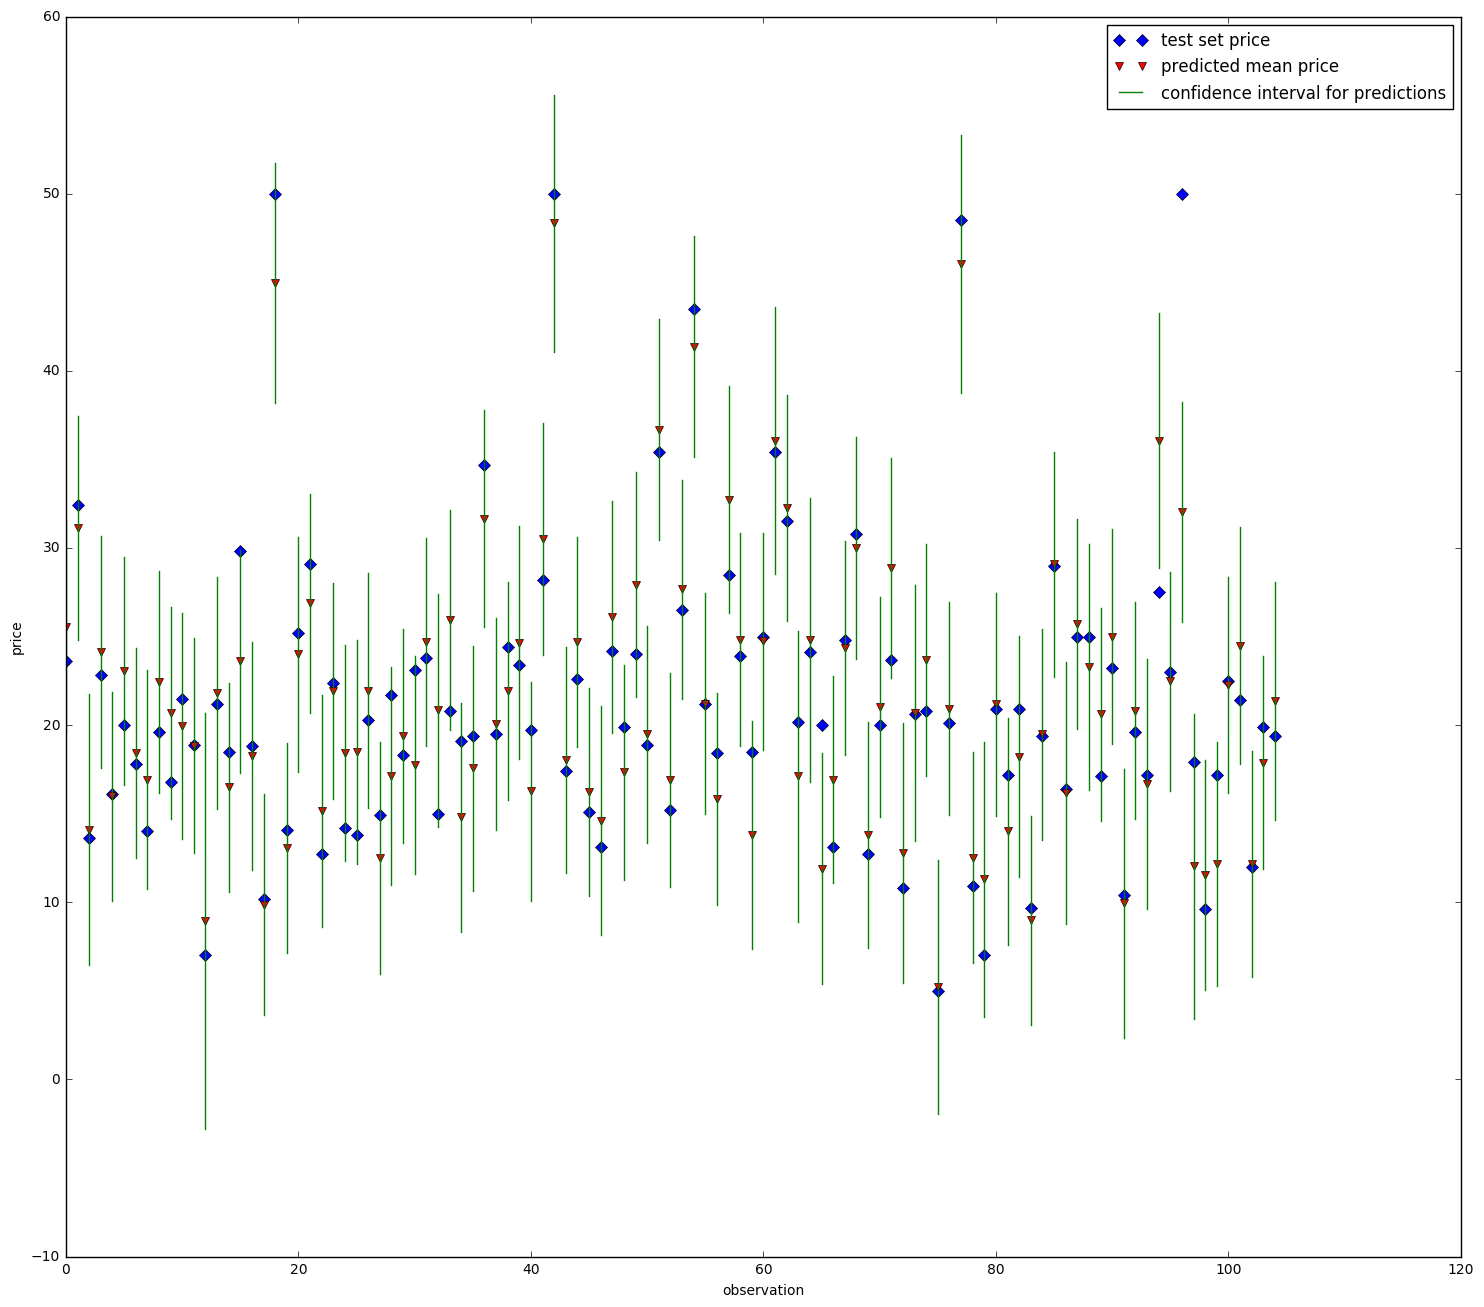

In [8]:
%matplotlib inline
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in np.arange(0,len(y_test)-1):
    plt.plot(i, y_test[i][0], 'Db', label='test set price' if i == 0 else "")
    plt.plot(i, cmean[i][0], 'vr', label='predicted mean price' if i == 0 else "")
    plt.plot([i, i], [clower[i][0], cupper[i][0]],
             '-g', linewidth=1, label='confidence interval for predictions' if i == 0 else "")
plt.xlabel('observation')
plt.ylabel('price')
plt.legend()
plt.show()

In [10]:
myrmse = rmse(y_test, cmean)
print "The RMSE error is {}".format(myrmse)

mae = mean_absolute_error(y_test, cmean)
print "The MAE is {}".format(mae)

mse = mean_squared_error(y_test, cmean)
print "The MSE is {}".format(mse)

pred_density = np.mean(cmodel.log_predictive_density(X_test, y_test))
print "The predictive density is {}".format(pred_density)

The RMSE error is 3.26774585597
The MAE is 2.2723327998
The MSE is 10.6781629792
The predictive density is -2.6084614461


It is seen that by combining using the sum the RBF and Polynomial Kernel it is obtained a lower MSE, MAE and RMSE which implies a more accurate GP model has been fitted. 

### 3. Leave-one-out CV

Using the whole dataset, employ a LOO-CV to evaluate the prediction error

Caution: optimize only once the kernel parameters, and be concious that this is a lengthy operation

In [11]:
loo = LeaveOneOut()
i   = 1

#Declare kernel
cvkern = GPy.kern.RBF(input_dim=13)

for train_index, test_index in loo.split(X):    
    #Get the train and test data set, 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Reshape the y vector
    y_train = np.reshape(y_train, (y_train.size,1))
    y_test = np.reshape(y_test, (y_test.size,1))

    #Declare Gaussian Process regressor
    cvmodel = GPy.models.GPRegression(X_train, y_train, cvkern)

    #Optimize
    cvmodel.optimize()
    print cvmodel
    
    #Predict
    [cvmean,cvvar] = cvmodel.predict(X_test, full_cov=False)
    
    #Get prediction error
    myrmse = rmse(y_test, cvmean)
    print "The RMSE error is {}".format(myrmse)

    mae = mean_absolute_error(y_test, cvmean)
    print "The MAE is {}".format(mae)

    mse = mean_squared_error(y_test, cvmean)
    print "The MSE is {}".format(mse)

    pred_density = np.mean(cvmodel.log_predictive_density(X_test, y_test))
    print "The predictive density is {}".format(pred_density)
    
    i += 1
    print "Procesing {} \n\n\n".format(i)
     
     


Name : GP regression
Objective : 1471.11607402
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  8938433.32927  |      +ve      |        
  rbf.lengthscale          |   639.24238968  |      +ve      |        
  Gaussian_noise.variance  |  9.22020645516  |      +ve      |        
The RMSE error is 2.97001122683
The MAE is 2.97001122683
The MSE is 8.82096668751
The predictive density is -2.51218638854
Procesing 2 





 /home/alessandro/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1



Name : GP regression
Objective : 1471.30372317
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  8938433.32927  |      +ve      |        
  rbf.lengthscale          |  639.205720238  |      +ve      |        
  Gaussian_noise.variance  |  9.22977277339  |      +ve      |        
The RMSE error is 2.27608629838
The MAE is 2.27608629838
The MSE is 5.18056883766
The predictive density is -2.32476706527
Procesing 3 




Name : GP regression
Objective : 1471.40691151
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  8938433.32927  |      +ve      |        
  rbf.lengthscale          |  639.164040927  |      +ve      |        
  Gaussian_noise.variance  |  9.23056821235  |      +ve      |        
The RMSE error is